# Performance Benchmarking: A Comparative Analysis of My Controller and a State-of-the-Art Benchmark

## Introduction

In this notebook the performance of the algorithm proposed as the solution of the first assignment of the Research Track 1 course (we'll call it controller 1) will be compared to the performance of another algorithm that was proposed as a standard solution to the same assignment (we'll call it controller 2). The performance evaluation extends to 46 trials, at every trial the arena where the robots are being tested gets modified and both controllers get tested on the same randomly generated map.
The analysis focuses on lap times, so how fast can the robot complete a full lap around the 'sunny side up arena' map, additionally the number of missed silver tokens and failed laps will also be considered. All data has been automatically measured by scripts integrated into the controller's code.

Since we're taking more than 30 samples for each variable in each run, we can expext the resulting lap times to follow a normal distribution and thus a paired t-test can be performed to compare the two algorithm's performances. Here are the null and the alternative hypotheses, respectively $H_{0}$ and $H_{a}$.
$$
H_{0} : \mu_{1} = \mu_{2}
$$
$$
H_{a} : \mu_{1} < \mu_{2}
$$

Where $\mu_{1}$ and $\mu_{2}$ are the average lap times of controller 1 and controller 2 respectively, so we're posing as an alternative hypothesis that controller 1 is on average faster than controller 2 around our track. The significance level assumed for this analysis is $\alpha=0.05$.



## Extracting data from log file
 Before we analyze our data we have to extract it from our formatted log file. We'll save lap times, number of failed object grasps and number of failed object detections in three lists and the number of failed trials in a dnf variable that we'll later explain in more detail.


In [1]:
import re
import random

def extract_data(filename, controller):
    seconds_list = []
    failed_grabs_list = []
    missed_tokens_list = []
    dnf=0
    
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        
        for i in range(len(lines)):
            if controller in lines[i].strip().split(' '):
                dnf_flag=1
                while(lines[i].strip() != '---------------------------'):
                    if 'loop' in lines[i].strip().split(' '):
                        seconds_list.append(lines[i].strip().split(' ')[6])
                        missed_tokens_list.append(int(lines[i].strip().split(' ')[17]))
                        failed_grabs_list.append(int(lines[i].strip().split(' ')[13]))
                        dnf_flag=0
                    i +=1
                if dnf_flag==1:
                    dnf+=1
                    
    return seconds_list, missed_tokens_list, failed_grabs_list, dnf

filename = 'test.txt'

controller1_seconds, missed1, failed1, dnf1 = extract_data(filename, 'assignment_1_controller')
controller2_seconds, missed2, failed2, dnf2 = extract_data(filename, 'benchmark_controller')



## Data Visualization
Now that we have our data saved in lists and variables, we can visualize it more clearly by using functions from the seaborn, matplotlib and scipy libraries.

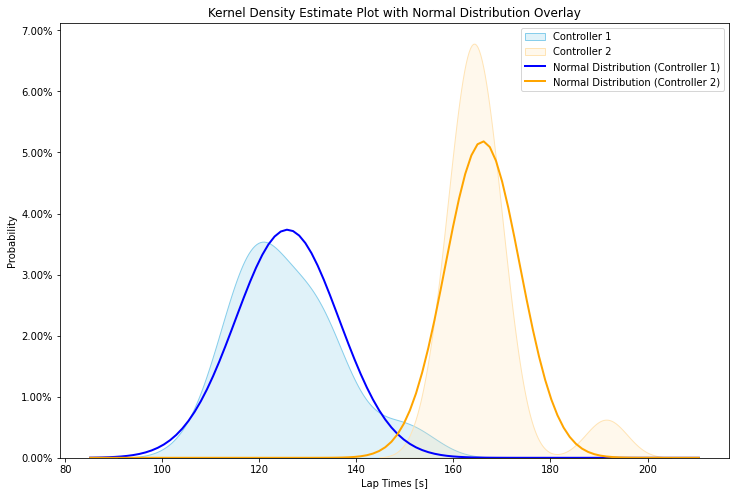

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


# convert data to floats
data1 = [float(value) for value in controller1_seconds]
data2 = [float(value) for value in controller2_seconds]

# Set a larger figure size
plt.figure(figsize=(12, 8))

# create a KDE plot with actual probability on the y-axis
sns.kdeplot(data1, color="skyblue", fill=True, label="Controller 1", common_norm=False)
sns.kdeplot(data2, color="moccasin", fill=True, label="Controller 2", common_norm=False)

# manually adjust y-axis ticks to represent probabilities
plt.yticks(plt.yticks()[0], [f'{tick:.2%}' for tick in plt.yticks()[0]])

# overlay a normal distribution on the plot
xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)
mu, std = np.mean(data1), np.std(data1)
p = norm.pdf(x, mu, std)
plt.plot(x, p, linewidth=2, label="Normal Distribution (Controller 1)",color="blue")

mu, std = np.mean(data2), np.std(data2)
p = norm.pdf(x, mu, std)
plt.plot(x, p, linewidth=2, label="Normal Distribution (Controller 2)",color="orange")

# Set labels and title
plt.xlabel("Lap Times [s]")
plt.ylabel("Probability")
plt.title("Kernel Density Estimate Plot with Normal Distribution Overlay")

# Show the legend
plt.legend()

# Show the plot
plt.show()


## Data Analysis

From the graph we just plotted, it's clear that, given the sample size, the probability density functions derived from our samples more or less follow their normal curves. This means that to compare the results of our two different controllers, we can perform a t-test to validate or refute our alternate hypothesis $H_{a}$.

In [3]:
# uncomment if the scipy package is missing:
# !pip3 install scipy
# remove excess elements from the longer list


from IPython.display import HTML, display
from scipy import stats
from scipy.stats import ttest_rel


def display_table(data):
    html = "<table style='width:50%'>"  
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4></td>" % (field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

# compare the lengths of the two lists
len1 = len(data1)
len2 = len(data2)

#to perform the test we need to get the same number of samples from our controllers' recorded lap times
if len1 > len2:
    data1 = random.sample(data1, len2)
elif len2 > len1:
    data2 = random.sample(data2, len1)


# compare the two datasets and get T and P values
t_value, p_value = stats.ttest_rel(data1, data2)


data = [['T-value:', t_value], ['P-value:', p_value]]
display_table(data)
one_tailed_p_value = float("{:.18f}".format(p_value / 2))

T-value:,-16.430343405376878
P-value:,3.1341773760916857e-16


 Since the $H_{a}$ we've set is a directional hypothesis, to check if our results are statistically significant, we can simply check if  $\frac{pvalue}{2}<\alpha$ in a one tailed test. Considering that we set a significance level of 5%, our result of $\frac{pvalue}{2}$={{one_tailed_p_value}} clearly satisfies the conditions to accept our alternate hypothesis. Considering then also our negative T value, we can confidently state that on average controller 1 will be expected to be faster at guiding our robot around the track than controlller 2, which is considered as a standard solution to this problem.  
 
 These results have been gathered from the times that both controllers managed to finish a lap track in under 200 seconds, since it has been decided that, for the purpose of testing, a lap time over 200 seconds means that the robot has either crashed permanently into a wall or that it has turned around and has wasted time traversing the track the wrong way around. Both of these occurrences are counted under the 'dnf' variable for both controllers, here's a representation of both controllers' dnf percentage: 

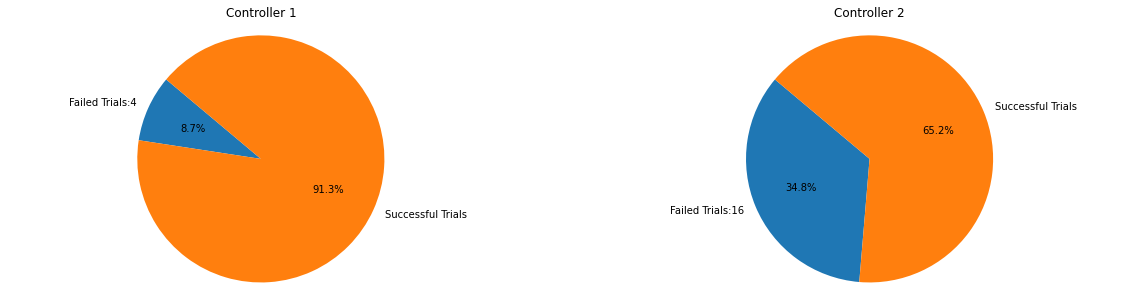

In [4]:
import matplotlib.pyplot as plt


dnf_percentage1 = dnf1/46 * 100
labels1 = [f'Failed Trials:{dnf1}', 'Successful Trials']
sizes1 = [dnf_percentage1, 100 - dnf_percentage1]

dnf_percentage2 = dnf2/46 * 100
labels2 = [f'Failed Trials:{dnf2}', 'Successful Trials']
sizes2 = [dnf_percentage2, 100 - dnf_percentage2]

plt.figure(figsize=(20, 5))
plt1 = plt.subplot(1, 2, 1)
plt2 = plt.subplot(1, 2, 2)

plt1.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=140)
plt1.axis('equal')
plt1.set_title('Controller 1')

plt2.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=140)
plt2.axis('equal')
plt2.set_title('Controller 2')

# Show the pie chart
plt.show()


From these charts we can see that in the trials performed controller 1 has also had a lower dnf rate than controller2.

Lastly, we can visualize how effective the two controllers are at detecting and moving silver tokens out of the robot's path by summing the number of all recorded missed objects and plotting them in two other pie charts.

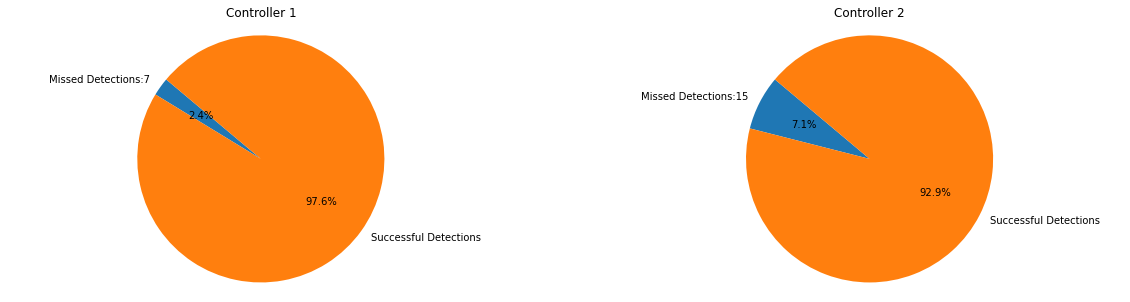

In [5]:
import matplotlib.pyplot as plt

objects_encountered1 = len1 * 7

missed_detections1 = sum(missed1)
missed_percentage1 = missed_detections1 / objects_encountered1 * 100
labels1 = [f'Missed Detections:{missed_detections1}', 'Successful Detections']
sizes1 = [missed_percentage1, 100 - missed_percentage1]

objects_encountered2 = len2 * 7
missed_detections2 = sum(missed2)
missed_percentage2 = missed_detections2 / objects_encountered2 * 100
labels2 = [f'Missed Detections:{missed_detections2}', 'Successful Detections']
sizes2 = [missed_percentage2, 100 - missed_percentage2]

plt.figure(figsize=(20, 5))
plt1 = plt.subplot(1, 2, 1)
plt2 = plt.subplot(1, 2, 2)

plt1.pie(sizes1, labels=labels1, autopct='%1.1f%%', startangle=140)
plt1.axis('equal')
plt1.set_title('Controller 1')

plt2.pie(sizes2, labels=labels2, autopct='%1.1f%%', startangle=140)
plt2.axis('equal')
plt2.set_title('Controller 2')

# Show the pie chart
plt.show()


## Conclusions

Under the testing conditions described in this repository, we can infer that controller 1 can drive the robot faster than controller 2 around a track where silver tokens are spawned randomly within the limits of the track. Controller 1 has also demonstrated a higher success rate at detecting silver tokens and has been able to succesfully complete track laps more often than controller2 over the trials performed.